Problem description

in this problem we are going to predict the number of cases of dengue through weather data to help with the determination of how much support is needed in areas with certian weather characteristics

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dengue-prediction/final.csv


Loading data and getting some high level data

In [37]:
data = pd.read_csv('/kaggle/input/dengue-prediction/final.csv')
print(data.head())
print(data.info)

   serial    tempmax    tempmin       temp  feelslikemax  feelslikemin  \
0       0  34.053151  24.478082  28.709863     39.757808     25.317808   
1       1  34.086179  25.694309  29.464228     41.338211     28.140650   
2       2  34.573984  25.417886  29.526829     40.464228     26.560163   
3       3  33.020325  25.080488  28.727642     37.878049     26.193496   
4       4  30.660976  24.230894  26.774797     36.586992     24.263415   

   feelslike        dew   humidity     precip  ...  sealevelpressure  \
0  32.306301  22.971233  73.508219   2.921726  ...       1007.911781   
1  34.423577  23.484553  72.066667   3.783415  ...       1003.533333   
2  33.085366  22.580488  69.424390   3.065854  ...       1005.731707   
3  31.772358  21.752033  69.297561   6.025203  ...       1003.359350   
4  28.943902  24.214634  86.652033  23.336585  ...       1009.995935   

   cloudcover  visibility  solarradiation  solarenergy   uvindex  conditions  \
0   50.747945    3.789863      208.097808 

individual features look clean with little reason to do in column data cleaning.
next step is to drop columns that are not useful and to split data into testing and training data sets. 

In [38]:
from sklearn.model_selection import train_test_split
columns_to_drop = ['serial','labels']
data = data.drop(columns=columns_to_drop)


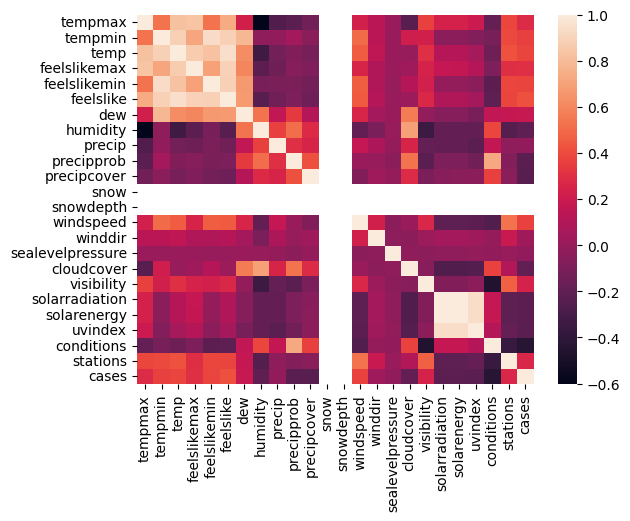

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.corr()
sns.heatmap(correlation_matrix)
plt.show()

snow and snowdepth show no correlation to any other variables and will be removed from data set

In [40]:
columns_to_drop = ['snow','snowdepth']
data = data.drop(columns=columns_to_drop)

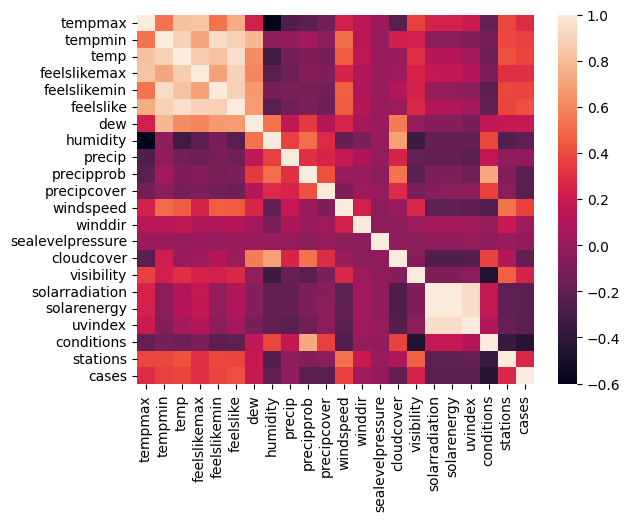

In [41]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix)
plt.show()

from the heatmap we can see that cases has the highest correlation with conditions.

In [42]:

X = data.drop('cases', axis=1)
y = data['cases']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=123)

In [43]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train['conditions']).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  cases   R-squared (uncentered):                   0.239
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              169.7
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                    6.22e-34
Time:                        15:43:30   Log-Likelihood:                         -5725.8
No. Observations:                 541   AIC:                                  1.145e+04
Df Residuals:                     540   BIC:                                  1.146e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

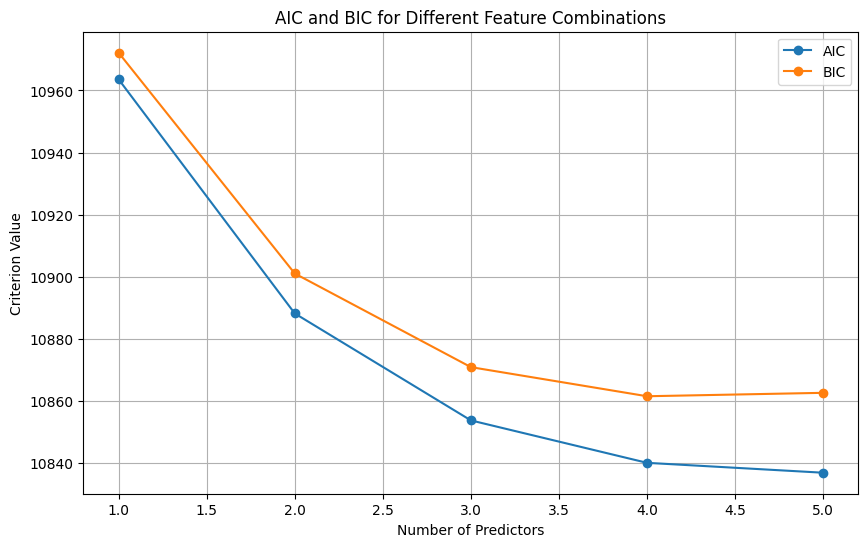

Best 1 Predictors: conditions (AIC=10963.587483536645, BIC=10972.174322094337)
Best 2 Predictors: feelslike, conditions (AIC=10888.111978668398, BIC=10900.992236504937)
Best 3 Predictors: feelslike, uvindex, conditions (AIC=10853.62686891243, BIC=10870.800546027816)
Best 4 Predictors: feelslike, cloudcover, uvindex, conditions (AIC=10839.948378173332, BIC=10861.415474567564)
Best 5 Predictors: feelslike, sealevelpressure, cloudcover, solarenergy, conditions (AIC=10836.757770489576, BIC=10862.518286162654)


In [48]:
import itertools

best_combinations = {}
best_aic = {}
best_bic = {}
best_predictors = {}
n_features = len(X_train.columns) 

# Loop through all combinations of feature indices
for k in range(1, 6):
    best_aic_k = float('inf')
    best_bic_k = float('inf')
    best_predictors_k = None

    for combo in itertools.combinations(X_train, k):
        X = X_train[list(combo)]

        # Fit a linear regression model
        X = sm.add_constant(X)
        model = sm.OLS(y_train, X).fit()

        # Calculate AIC and BIC
        aic = model.aic
        bic = model.bic

        if aic < best_aic_k:
            best_aic_k = aic
            best_bic_k = bic
            best_predictors_k = combo

    best_combinations[k] = best_predictors_k
    best_aic[k] = best_aic_k
    best_bic[k] = best_bic_k
    best_predictors[k] = best_predictors_k

# Create graphs for AIC and BIC
plt.figure(figsize=(10, 6))
plt.plot(list(best_aic.keys()), list(best_aic.values()), label='AIC', marker='o')
plt.plot(list(best_bic.keys()), list(best_bic.values()), label='BIC', marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('Criterion Value')
plt.legend()
plt.title('AIC and BIC for Different Feature Combinations')
plt.grid()
plt.show()

# Print the best predictors for each combination size
for k, predictors in best_predictors.items():
    print(f'Best {k} Predictors: {", ".join(predictors)} (AIC={best_aic[k]}, BIC={best_bic[k]})')


In [59]:
model_3 = sm.OLS(y_train, X_train[['feelslike', 'uvindex', 'conditions']]).fit()
print(model_3.summary())

model_4 = sm.OLS(y_train, X_train[['feelslike', 'cloudcover','uvindex', 'conditions']]).fit()
print(model_4.summary())

#f test
f_stat = ((model_4.ssr - model_3.ssr) / (3-4)) / (model_3.ssr / (n_features - 3))

print('the f statistic is ' + str(f_stat))

                                 OLS Regression Results                                
Dep. Variable:                  cases   R-squared (uncentered):                   0.751
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              541.5
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                   4.90e-162
Time:                        16:07:12   Log-Likelihood:                         -5423.4
No. Observations:                 541   AIC:                                  1.085e+04
Df Residuals:                     538   BIC:                                  1.087e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

by finding that the f statistic and being higher than a standard alpha of 0.05 w can determine that a linear model with 3 predictors does better than model with 4 predictors

Text(0.5, 1.0, 'Predicted vs. Actual Values')

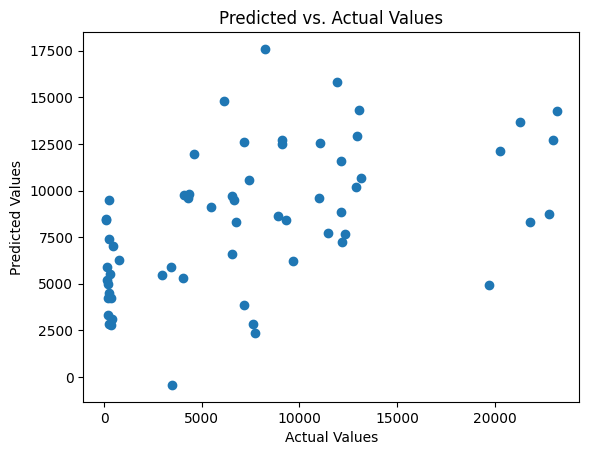

In [63]:
final_model = model_3

y_pred = final_model.predict(X_test[['feelslike', 'uvindex', 'conditions']])

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")

looking at predicted vs actual graph above there does seem to be a correlation between actual and predicted values but a decent amount of variance. 